In [1]:
import pandas as pd
import numpy as np
#import tensorflow as tf 
import os
import sys
from datetime import datetime, timedelta
from tqdm.autonotebook import tqdm
import csv
import re
from xgboost import XGBClassifier
import scikitplot as skplt
import gzip
import shutil
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [2]:
path = '/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/icu/'

In [3]:
new_path = '/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/'

In [4]:
hos_path = '/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/hosp/'

In [24]:
import pickle
with gzip.open(new_path+'new_dict/20221119_death_dataset_plus.pickle','rb') as f:  
    death_dataset = pickle.load(f)

In [6]:
with gzip.open(hos_path+'patients.csv.gz') as f:
    patients = pd.read_csv(f, chunksize=10**2)
    patients = list(patients)
    patients = pd.concat(patients)
print(patients.shape)

(315460, 6)


In [7]:
with gzip.open(hos_path+'admissions.csv.gz') as f:
    admissions = pd.read_csv(f, chunksize=10**2)
    admissions = list(admissions)
    admissions = pd.concat(admissions)
print(admissions.shape)

(454324, 15)


In [8]:
patients

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN
...,...,...,...,...,...,...
315455,19999828,F,46,2147,2017 - 2019,NaN
315456,19999829,F,28,2186,2008 - 2010,NaN
315457,19999840,M,58,2164,2008 - 2010,2164-09-17
315458,19999914,F,49,2158,2017 - 2019,NaN


In [8]:
peni_id = pd.read_csv(new_path+'new_csv/id_peni.csv')
macro_id = pd.read_csv(new_path+'new_csv/id_macro.csv')
glyco_id = pd.read_csv(new_path+'new_csv/id_glyco.csv')
fluoro_id = pd.read_csv(new_path+'new_csv/id_fluoro.csv')
cepha_id = pd.read_csv(new_path+'new_csv/id_cepha.csv')

In [9]:
## Define some util functions
NOT_CONVERTED = 'NOT_CONVERTED'
## 문자로 기록된 날짜 값들을 파이썬의 datetime 데이터로 바꿔주는 함수 작성
def str2datetime(s):
    def _convert(_s, _dformat):
        try:
            converted_dt = datetime.strptime(_s, _dformat)
        except Exception:
            return NOT_CONVERTED

        return converted_dt

    if isinstance(s, datetime):
        return s

    dformats = [
        '%Y-%m-%d %p %I:%M:%S',
        '%Y-%m-%d %H:%M:%S.%f',
        '%Y-%m-%d %H:%M:%S',
        '%Y-%m-%d %H:%M',
        '%y-%m-%d %H:%M',
        '%Y-%m-%d',
        '%Y%m%d',
        '%Y-%m-%d +%H:%M',
        '%Y%m%d %H%M',
        '%Y%m%d%H%M%S',
        ]

    s = s.split('.')[0]
    s = s.replace('오전', 'am').replace('오후', 'pm')
    for dformat in dformats:
        dt = _convert(s, dformat)
        if dt != NOT_CONVERTED:
            return dt

    return NOT_CONVERTED

In [10]:
# 사망 레이블 하기
death_labels = dict()
admissions = csv.DictReader(open("/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimiciv_der/sepsis3_admissions.csv", 'r', encoding='utf-8'))
for row in tqdm(admissions, desc='Get Death Label'):
    hadm_id = row['hadm_id']
    death_yn = int(row['hospital_expire_flag'])
    if death_yn:
        event_time = str2datetime(row['deathtime'])
    else:
        event_time = str2datetime(row['dischtime'])
        death_labels[hadm_id] = dict({'DEATH': death_yn, 'EVENT_TIME': event_time})

Get Death Label: 0it [00:00, ?it/s]

In [11]:
# 재실 기간 레이블 하기
los_labels = dict()
admissions = csv.DictReader(open('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimiciv_der/sepsis3_admissions.csv', 'r', encoding='utf-8'))
for row in tqdm(admissions, desc='Get loss Label'):
    hadm_id = row['hadm_id']
    admin_time = str2datetime(row['admittime'])
    disc_time = str2datetime(row['dischtime'])
    los = (disc_time - admin_time).total_seconds() / (60*60)
    los_labels[hadm_id] = int(los)

Get loss Label: 0it [00:00, ?it/s]

In [15]:
hadm_ids = death_dataset['HADM_IDS']

In [16]:
## 환자의 입실 퇴실 시간 정보 가져오기
Extracted_HADMIDS = hadm_ids
admin_disc_time = dict()

admissions = csv.DictReader(open('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimiciv_der/sepsis3_admissions.csv', 'r', encoding='utf-8'))
for row in admissions:
    hadm_id = row['hadm_id']
    admin_time = str2datetime(row['admittime'])
    disc_time = str2datetime(row['dischtime'])

    if (admin_time != NOT_CONVERTED) and (disc_time != NOT_CONVERTED):
        admin_disc_time[hadm_id] = dict({'ADMIN': admin_time, 'DISC': disc_time})

In [17]:
## 입실 시점으로부터 1시간 간격으로 데이터를 읽어오는 함수 정의
def quantize_features(feature_list, admin_time, disc_time, missing_feature=False):
    total_hours = int((disc_time - admin_time).total_seconds() / (60*60))
  #입실 이후 최대 24시간 동안의 데이터만 가져오기
    if total_hours > 24:
        total_hours = 24

    quantized_features = list()
    if missing_feature:
        for i in range(total_hours):
            quantized_time = admin_time + timedelta(hours=i)
            quantized_value = np.nan #지금은 dic 형태라, pandas 쓰면 NAN이랑 동일, carry forward 도 가능
            quantized_features.append((quantized_time, quantized_value))
    else:
        feature_list = list(sorted(feature_list, key=lambda x: x[0]))
        for i in range(total_hours):
            quantized_time = admin_time + timedelta(hours=i)
            quantized_time_start = quantized_time - timedelta(hours=1)
            quantized_values = list(filter(lambda x: quantized_time_start < x[0] <= quantized_time, feature_list)) #filter함수 True만 필터
            if len(quantized_values) > 0:
                quantized_value = quantized_values[-1][1]
            else:
                quantized_value = np.nan 

            quantized_features.append((quantized_time, quantized_value))

    return quantized_features

In [18]:
feature_keys = ['FiO2', 'HR', 'PaO2', 'SBP', 'Temperature','Creatinine','Glucose', 'Hb', 'Lactate', 'Plt','Sodium' ,'WBC','DBP', 'MAP', 'RESP', 'Chloride', 'Hct', 'PCO2', 'Potassium', 'PH', 'Anion Gap', 'Bilirubin']

EXTRACT_FEATURE_CODES_VS = dict({
    '226754': 'FiO2', '223835': 'FiO2', '227010': 'FiO2', '229280': 'FiO2', '229841': 'FiO2',
    '220045': 'HR', '220046': 'HR', '226764': 'HR', '227018': 'HR',
    '220224': 'PaO2', '227039': 'PaO2', '227516': 'PaO2',
    '220050': 'SBP' ,'220179': 'SBP', '224167': 'SBP', '227243': 'SBP', '228152': 'SBP',
    '223762': 'Temperature', '226329': 'Temperature', '227632': 'Temperature', '227634': 'Temperature',
    '50825': 'Temperature',
    ####### 새로운 features ##########
   '223761': 'TEMP_F',
   '225310': 'DBP', '220051': 'DBP', '220180': 'DBP',
   '225312': 'MAP', '220052': 'MAP', '220181': 'MAP',
   '220210': 'RESP', '224690': 'RESP'
    })
EXTRACT_FEATURE_CODES_LAB = dict({
    '220615': 'Creatinine', '229761': 'Creatinine',
    '52024': 'Creatinine', '50912': 'Creatinine', '52546': 'Creatinine', '51977': 'Creatinine',  '51081': 'Creatinine',
    '220621': 'Glucose', '225664': 'Glucose', '226537': 'Glucose',
    '50809': 'Glucose', '52027': 'Glucose', '50931': 'Glucose', '52569': 'Glucose', '51981': 'Glucose', '51478': 'Glucose',
    '220228': 'Hb',
    '50811': 'Hb', '50855': 'Hb', '51640': 'Hb', '51645': 'Hb', '51222': 'Hb', '52157': 'Hb',
    '225668': 'Lactate',
    '50813': 'Lactate', '52442': 'Lactate',
    '227457': 'Plt',
    '51704': 'Plt', '51265': 'Plt',
    '220645': 'Sodium', '226534': 'Sodium',
    '50824': 'Sodium', '52455': 'Sodium', '50983': 'Sodium', '52623': 'Sodium',
    '220546': 'WBC',
    '51755': 'WBC', '51756': 'WBC', '51301': 'WBC',
    ######### 새로운 features ############
    '50902': 'Chloride', '50806': 'Chloride',
    '50810': 'Hct', '51221': 'Hct',
    '50810': 'PCO2',
    '50822': 'Potassium', '50971': 'Potassium', '845825': 'Potassium',
    '50820': 'PH',
    '50868': 'Anion Gap', '769895': 'Anion Gap', '52456': 'Anion Gap', 
    '50885': 'Bilirubin'})

EXTRACT_FEATURE_CODES_NORMAL = dict({ #outlier 범위 - medical knowledge에 기반하여 계산
        'FiO2': [10, 100],
        'HR': [30, 200],
        'PaO2': [50, 200],
        'SBP': [40, 250],
        'Temperature': [30, 45],
        'Creatinine': [0.2, 100],
        'Glucose': [30, 1000],
        'Hb': [5, 20],
        'Lactate': [0.5, 2.5],
        'Plt': [10, 500],
        'Sodium': [90, 170],
        'WBC': [1, 30],
        'DBP':[30, 200],
        'MAP':[33, 216],
        'RESP':[0, 35],
        'Chloride':[70, 130],
        'Hct':[10, 50], 
        'PCO2':[5, 100],
        'Potassium':[1.0, 10.0],
        'PH':[5.5, 8.0],
        'Anion Gap':[5, 50],
        'Bilirubin':[0.1, 10]
})
NORMAL_VALUE = dict({ #missing value 대체값
        'FiO2': 40,
        'HR': 75, #(50+100)/2
        'PaO2': 87.5, #(75+100)/2
        'SBP': 115, #(90+140)/2 = 115
        'Temperature': 36.65, #(36.1+37.2)/2
        'Creatinine': 1.0, #(0.7+1.0)/2
        'Glucose': 100, #(60+140)/2
        'Hb': 15.0, #(13.8+17.2)/2
        'Lactate': 1.35, #(0.5+2.2)/2 = 1.35
        'Plt': 270, #(140+400)/2
        'Sodium': 140, #(135+145)/2
        'WBC': 7.5, #(5+10)/2
        'WBC': 7.5, #(5+10)/2
        'DBP': 90, #(80+100)/2 
        'MAP': 98, # (115 + 2*90) / 
        'RESP': 13, 
        'Chloride': 102, #(96+108) / 2
        'Hct': 34.5, #(34+45)/2
        'PCO2': 40, #(35+45)/2
        'Potassium': 4.5, #(3.5+5.4)/2
        'PH': 7.4, #(7.35 + 7.45) / 2
        'Anion Gap': 14, #8+20/2
        'Bilirubin': 0.8 #0+1.5/2
})

In [20]:
total_death_included_hadm_ids = list(death_labels.keys())
total_los_included_hadm_ids = list(los_labels.keys())

## 길이 24로 맞추기 

In [27]:
for i in range(len(death_dataset['DATA'])):
    if (death_dataset['DATA'][i].shape[0]) < 24:
        zeros = np.zeros((24, death_dataset['DATA'][i].shape[1]))
        zeros[:death_dataset['DATA'][i].shape[0], :] = death_dataset['DATA'][i]
        death_dataset['DATA'][i] = zeros
    else:
        death_dataset['DATA'][i] = death_dataset['DATA'][i][:24] 

In [292]:
# case_X = np.zeros((5 ,22, 24))
# case_y = np.zeros((5, 1))
j = 0
for idx, i in (enumerate(tqdm(death_dataset['HADM_IDS']))):
    if int(i) in [22764516, 20462195, 26543049, 21311611, 23869046]:
        if int(i) in peni_id['hadm_id'].tolist():
                print('peni', i)
        elif int(i) in glyco_id['hadm_id'].tolist():
                print('glyco', i)
        elif int(i) in fluoro_id['hadm_id'].tolist():
                print('fluoro', i)
        elif int(i) in cepha_id['hadm_id'].tolist():
                print('cepha', i)
                #         case_X[j] = death_dataset['DATA'][idx].T
#         case_y[j] = death_dataset['LABEL'][idx]
        print(i)
#         j += 1


  0%|          | 0/32340 [00:00<?, ?it/s]

glyco 23869046
23869046
cepha 20462195
20462195
glyco 22764516
22764516
peni 26543049
26543049
glyco 21311611
21311611


In [288]:
case_X

array([[[0.33333333, 0.33333333, 1.        , ..., 0.55555556,
         0.55555556, 0.55555556],
        [0.24705882, 0.19411765, 0.22941176, ..., 0.15882353,
         0.16470588, 0.15294118],
        [0.25      , 0.08      , 0.52666667, ..., 0.52666667,
         0.52666667, 0.52666667],
        ...,
        [0.76      , 0.792     , 0.788     , ..., 0.788     ,
         0.788     , 0.788     ],
        [0.2       , 0.13333333, 0.13333333, ..., 0.2       ,
         0.2       , 0.2       ],
        [0.07070707, 0.06060606, 0.06060606, ..., 0.06060606,
         0.06060606, 0.06060606]],

       [[0.33333333, 0.33333333, 0.33333333, ..., 0.33333333,
         0.33333333, 0.33333333],
        [0.26470588, 0.26470588, 0.26470588, ..., 0.39411765,
         0.39411765, 0.4       ],
        [0.25      , 0.25      , 0.25      , ..., 0.25      ,
         0.25      , 0.25      ],
        ...,
        [0.76      , 0.76      , 0.76      , ..., 0.76      ,
         0.76      , 0.76      ],
        [0.2

In [263]:
case_X.shape

(5, 22, 24)

In [241]:
for idx, i in (enumerate(tqdm(death_dataset['HADM_IDS']))):
    if int(i) in [22764516, 20462195, 26543049, 21311611, 23869046]:
        pass

  0%|          | 0/32340 [00:00<?, ?it/s]

In [242]:
peni_X = np.zeros((len(peni_id) ,22, 24))
peni_y = np.zeros((len(peni_id), 1))
j = 0
for idx, i in (enumerate(tqdm(death_dataset['HADM_IDS']))):
    if int(i) in [22764516, 20462195, 26543049, 21311611, 23869046]:
        continue
    else:
        if int(i) in peni_id['hadm_id'].tolist():
            peni_X[j] = death_dataset['DATA'][idx].T
    #         print(death_dataset['DATA'][idx].reshape)
            peni_y[j] = death_dataset['LABEL'][idx]
            j += 1

  0%|          | 0/32340 [00:00<?, ?it/s]

In [244]:
macro_X = np.zeros((len(macro_id) ,22, 24))
macro_y = np.zeros((len(macro_id), 1))
j = 0
for idx, i in (enumerate(tqdm(death_dataset['HADM_IDS']))):
    if int(i) in [22764516, 20462195, 26543049, 21311611, 23869046]:
        continue
    else:
        if int(i) in macro_id['hadm_id'].tolist():
            macro_X[j] = death_dataset['DATA'][idx].T
    #         print(death_dataset['DATA'][idx].reshape)
            macro_y[j] = death_dataset['LABEL'][idx]
            j += 1

  0%|          | 0/32340 [00:00<?, ?it/s]

In [250]:
def making_num(id_df):
    X = np.zeros((len(id_df) ,22, 24))
    y = np.zeros((len(id_df), 1))
    j = 0
    for idx, i in (enumerate(tqdm(death_dataset['HADM_IDS']))):
        if int(i) in [22764516, 20462195, 26543049, 21311611, 23869046]:
            continue
        else:
            if int(i) in id_df['hadm_id'].tolist():
                X[j] = death_dataset['DATA'][idx].T
        #         print(death_dataset['DATA'][idx].reshape)
                y[j] = death_dataset['LABEL'][idx]
                j += 1
    print(X.shape, y.shape)
    return X, y

In [252]:
glyco_X, glyco_y = making_num(glyco_id)
fluoro_X, fluoro_y = making_num(fluoro_id)
cepha_X, cepha_y = making_num(cepha_id)

  0%|          | 0/32340 [00:00<?, ?it/s]

(11766, 22, 24) (11766, 1)


  0%|          | 0/32340 [00:00<?, ?it/s]

(3654, 22, 24) (3654, 1)


  0%|          | 0/32340 [00:00<?, ?it/s]

(10963, 22, 24) (10963, 1)


In [253]:
def X_concat(X):
    X_concat = np.zeros((len(X), 22, 51))
    for idx in tqdm(range(X.shape[0])):
    
        for idx2 in range(X.shape[1]):
            max_ = X[idx, idx2].max() 
            min_ = X[idx, idx2].min() 
            mean_ = X[idx, idx2].mean()
            ori_idx = list(range(0,47,2))
            del_idx = list(range(1,47,2))
            if (max_ + min_ == 1) :
                X_concat[idx, idx2, ori_idx] = [(i) for i in X[idx, idx2]]
            elif (max_ - min_ == 0): 
                X_concat[idx, idx2, ori_idx] = [(i)/max_ for i in X[idx, idx2]]
            else:
                X_concat[idx, idx2, ori_idx] = [(i - min_)/(max_ - min_) for i in X[idx, idx2]]
                
            X_concat[idx, idx2, del_idx] = [X[idx, idx2, i+1] - X[idx, idx2, i]  for i in range(0, 23)]
            X_concat[idx, idx2, 48:] = [max_, min_, mean_]
    return X_concat

In [254]:
fluoro_X_concat = X_concat(fluoro_X)
glyco_X_concat = X_concat(glyco_X)
macro_X_concat = X_concat(macro_X)
peni_X_concat = X_concat(peni_X)
cepha_X_concat = X_concat(cepha_X)
case_X_concat = X_concat(case_X)
print(fluoro_X_concat.shape, glyco_X_concat.shape,macro_X_concat.shape,peni_X_concat.shape, cepha_X_concat.shape, case_X_concat.shape)

  0%|          | 0/3654 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


  0%|          | 0/11766 [00:00<?, ?it/s]

  0%|          | 0/1920 [00:00<?, ?it/s]

  0%|          | 0/6072 [00:00<?, ?it/s]

  0%|          | 0/10963 [00:00<?, ?it/s]

(3654, 22, 51) (11766, 22, 51) (1920, 22, 51) (6072, 22, 51) (10963, 22, 51)


In [273]:
# re_cepha_X_concat = cepha_X_concat.reshape((len(cepha_X_concat), cepha_X_concat.shape[1]*cepha_X_concat.shape[2]))
# re_fluoro_X_concat = fluoro_X_concat.reshape((len(fluoro_X_concat), fluoro_X_concat.shape[1]*fluoro_X_concat.shape[2]))
# re_glyco_X_concat = glyco_X_concat.reshape((len(glyco_X_concat), glyco_X_concat.shape[1]*glyco_X_concat.shape[2]))
# re_macro_X_concat = macro_X_concat.reshape((len(macro_X_concat), macro_X_concat.shape[1]*macro_X_concat.shape[2]))
# re_peni_X_concat = peni_X_concat.reshape((len(peni_X_concat), peni_X_concat.shape[1]*peni_X_concat.shape[2]))
re_case_X_concat = case_X_concat.reshape((len(case_X_concat), case_X_concat.shape[1]*case_X_concat.shape[2]))

print(re_cepha_X_concat.shape, re_fluoro_X_concat.shape, re_glyco_X_concat.shape,re_macro_X_concat.shape, re_peni_X_concat.shape, re_case_X_concat.shape)

(10963, 1122) (3654, 1122) (11766, 1122) (1920, 1122) (6072, 1122) (5, 1122)


In [272]:
print(cepha_y.shape, fluoro_y.shape, glyco_y.shape,macro_y.shape, peni_y.shape, case_y.shape)

(10963, 1) (3654, 1) (11766, 1) (1920, 1) (6072, 1) (5, 1)


In [257]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [267]:
def prediction(X, y, case_id):
    x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, shuffle=True, stratify=y)
    xgb = XGBClassifier().fit(x_train, y_train)
    predictions = xgb.predict_proba(case_id)
    return predictions, y_valid, x_valid


In [268]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [274]:
peni_pred , y_valid, x_valid= prediction(re_peni_X_concat, peni_y, re_case_X_concat)

/home/je_hong/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/je_hong/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/je_hong/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, war

[17:03:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [278]:
macro_pred , y_valid, x_valid= prediction(re_macro_X_concat, macro_y,re_case_X_concat)

/home/je_hong/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/je_hong/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/je_hong/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, war

[17:07:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [280]:
glyco_pred , y_valid, x_valid= prediction(re_glyco_X_concat, glyco_y, re_case_X_concat)

/home/je_hong/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/je_hong/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/je_hong/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, war

[17:08:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [283]:
fluoro_pred , y_valid, x_valid= prediction(re_fluoro_X_concat, fluoro_y, re_case_X_concat)

/home/je_hong/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/je_hong/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/je_hong/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, war

[17:09:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [285]:
cepha_pred , y_valid, x_valid= prediction(re_cepha_X_concat, cepha_y, re_case_X_concat)

/home/je_hong/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/je_hong/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/je_hong/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, war

[17:10:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [275]:
y_pred = np.argmax(peni_pred, axis=1)

In [228]:
y_pred = np.argmax(macro_pred, axis=1)

In [234]:
y_pred = np.argmax(fluoro_pred, axis=1)

In [237]:
y_pred = np.argmax(cepha_pred, axis=1)

In [231]:
y_pred = np.argmax(glyco_pred, axis=1)

## peni

In [277]:
peni_pred

array([[0.37064683, 0.62935317],
       [0.7214063 , 0.27859372],
       [0.99689984, 0.00310015],
       [0.991773  , 0.00822702],
       [0.97378385, 0.02621617]], dtype=float32)

              precision    recall  f1-score   support

        dead     0.8357    0.9649    0.8957       485
    not_dead     0.6458    0.2520    0.3626       123

    accuracy                         0.8207       608
   macro avg     0.7408    0.6085    0.6291       608
weighted avg     0.7973    0.8207    0.7878       608



<AxesSubplot:title={'center':'Test Set'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

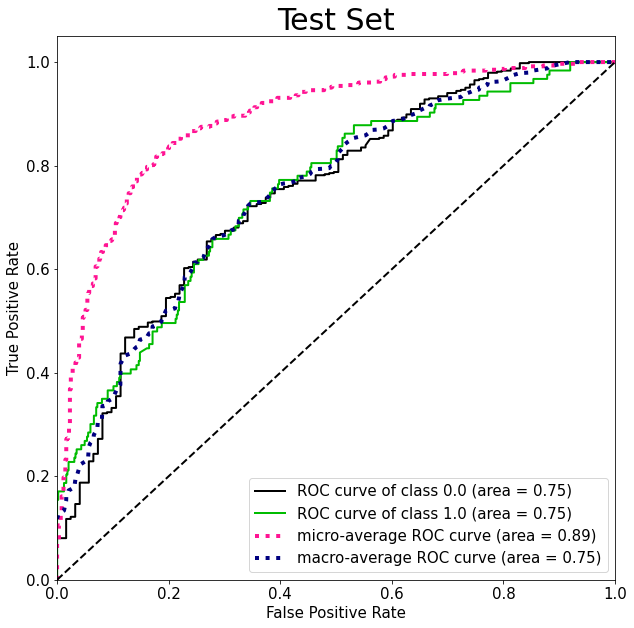

In [266]:
target_names = ['dead', 'not_dead']
print(classification_report(y_valid, y_pred, target_names=target_names, digits=4))
skplt.metrics.plot_roc(
    y_valid, peni_pred, title="Test Set", figsize=(10, 10), text_fontsize=15, title_fontsize=30,
)

In [ ]:
y_pred = np.argmax(, axis=1)

## macro

In [279]:
macro_pred

array([[0.99869347, 0.00130654],
       [0.9884068 , 0.01159324],
       [0.94360745, 0.05639256],
       [0.9108224 , 0.08917764],
       [0.97911507, 0.02088494]], dtype=float32)

In [282]:
case_y

array([[1.],
       [0.],
       [0.],
       [0.],
       [0.]])

              precision    recall  f1-score   support

        dead     0.8602    0.9877    0.9195       162
    not_dead     0.6667    0.1333    0.2222        30

    accuracy                         0.8542       192
   macro avg     0.7634    0.5605    0.5709       192
weighted avg     0.8300    0.8542    0.8106       192



<AxesSubplot:title={'center':'Test Set'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

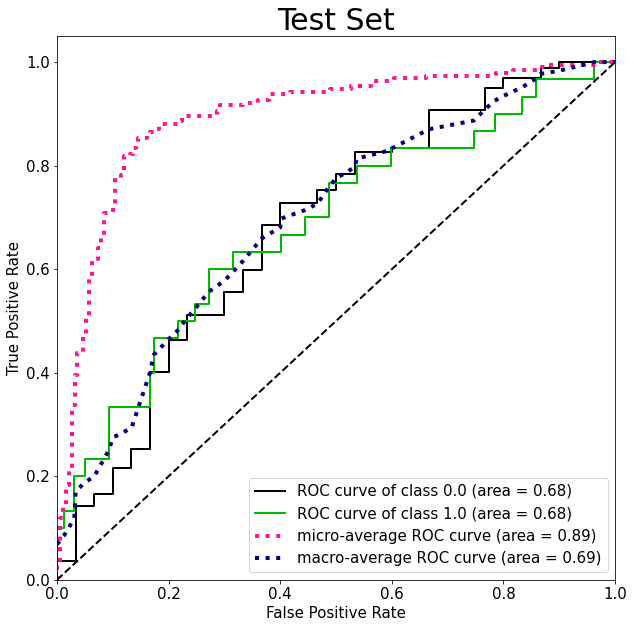

In [229]:
target_names = ['dead', 'not_dead']
print(classification_report(y_valid, y_pred, target_names=target_names, digits=4))
skplt.metrics.plot_roc(
    y_valid, macro_pred, title="Test Set", figsize=(10, 10), text_fontsize=15, title_fontsize=30,
)

## glyco

In [281]:
glyco_pred

array([[0.9399559 , 0.06004411],
       [0.77685905, 0.22314094],
       [0.5426438 , 0.4573562 ],
       [0.9538468 , 0.04615321],
       [0.9274587 , 0.07254132]], dtype=float32)

              precision    recall  f1-score   support

        dead     0.8253    0.9592    0.8872       931
    not_dead     0.6000    0.2317    0.3343       246

    accuracy                         0.8071      1177
   macro avg     0.7127    0.5954    0.6108      1177
weighted avg     0.7782    0.8071    0.7717      1177



<AxesSubplot:title={'center':'Test Set'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

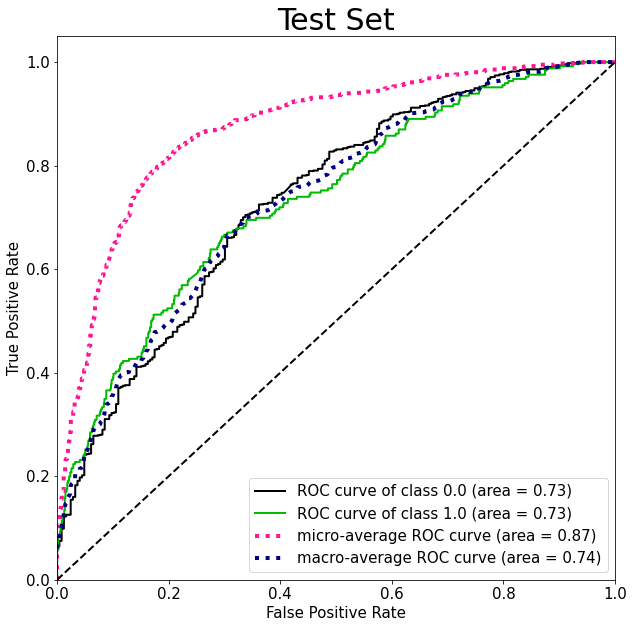

In [232]:
target_names = ['dead', 'not_dead']
print(classification_report(y_valid, y_pred, target_names=target_names, digits=4))
skplt.metrics.plot_roc(
    y_valid, glyco_pred, title="Test Set", figsize=(10, 10), text_fontsize=15, title_fontsize=30,
)

## fluoro

              precision    recall  f1-score   support

        dead     0.8718    0.9808    0.9231       312
    not_dead     0.6000    0.1667    0.2609        54

    accuracy                         0.8607       366
   macro avg     0.7359    0.5737    0.5920       366
weighted avg     0.8317    0.8607    0.8254       366



<AxesSubplot:title={'center':'Test Set'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

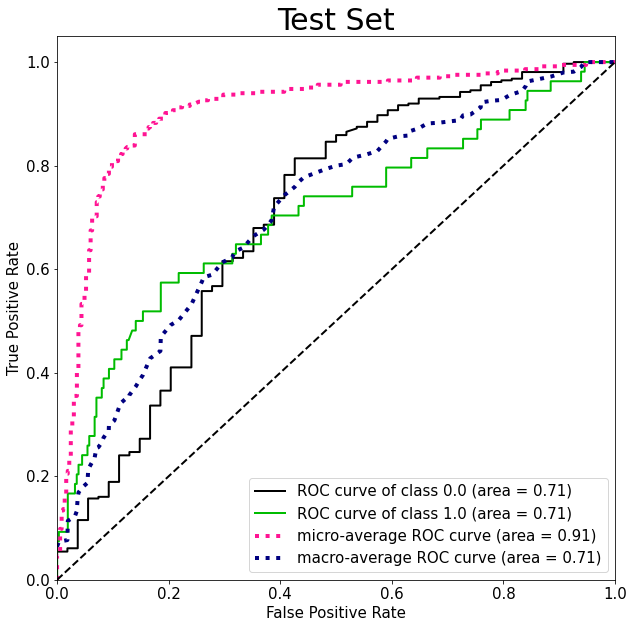

In [235]:
target_names = ['dead', 'not_dead']
print(classification_report(y_valid, y_pred, target_names=target_names, digits=4))
skplt.metrics.plot_roc(
    y_valid, fluoro_pred, title="Test Set", figsize=(10, 10), text_fontsize=15, title_fontsize=30,
)

In [284]:
fluoro_pred

array([[0.97404844, 0.02595158],
       [0.975314  , 0.024686  ],
       [0.8950972 , 0.10490278],
       [0.99448663, 0.00551335],
       [0.8949737 , 0.10502629]], dtype=float32)

## cepha

In [286]:
cepha_pred

array([[0.9897849 , 0.0102151 ],
       [0.728812  , 0.27118805],
       [0.91298616, 0.08701386],
       [0.96991646, 0.03008353],
       [0.9097274 , 0.09027259]], dtype=float32)

In [291]:
case_y

array([[1.],
       [0.],
       [0.],
       [0.],
       [0.]])

              precision    recall  f1-score   support

        dead     0.8822    0.9808    0.9289       939
    not_dead     0.6604    0.2215    0.3318       158

    accuracy                         0.8715      1097
   macro avg     0.7713    0.6012    0.6303      1097
weighted avg     0.8502    0.8715    0.8429      1097



<AxesSubplot:title={'center':'Test Set'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

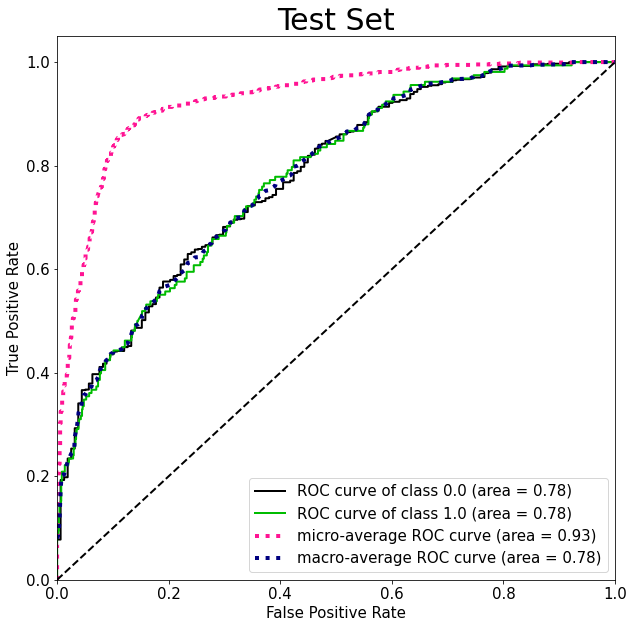

In [238]:
target_names = ['dead', 'not_dead']
print(classification_report(y_valid, y_pred, target_names=target_names, digits=4))
skplt.metrics.plot_roc(
    y_valid, cepha_pred, title="Test Set", figsize=(10, 10), text_fontsize=15, title_fontsize=30,
)